# Sentiment Analysis - World News Subreddit

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 800)

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.2") \
        .getOrCreate()

spark




Read multiple files in a dir as one Dataframe


In [3]:
# read a CSV file into a Spark DataFrame
df = spark.read.csv("reddit_worldnews_start_to_2016-11-22.csv/reddit_worldnews_start_to_2016-11-22.csv", header=True, inferSchema=True)

# show the first few rows of the DataFrame
df.show()

+------------+------------+--------+----------+--------------------+-------+--------------+---------+
|time_created|date_created|up_votes|down_votes|               title|over_18|        author|subreddit|
+------------+------------+--------+----------+--------------------+-------+--------------+---------+
|  1201232046|  2008-01-25|       3|         0|Scores killed in ...|  False|         polar|worldnews|
|  1201232075|  2008-01-25|       2|         0|Japan resumes ref...|  False|         polar|worldnews|
|  1201232523|  2008-01-25|       3|         0|US presses Egypt ...|  False|         polar|worldnews|
|  1201233290|  2008-01-25|       1|         0|Jump-start econom...|  False|       fadi420|worldnews|
|  1201274720|  2008-01-25|       4|         0|Council of Europe...|  False|      mhermans|worldnews|
|  1201287889|  2008-01-25|      15|         0|Hay presto! Farme...|  False|Armagedonovich|worldnews|
|  1201289438|  2008-01-25|       5|         0|Strikes, Protests...|  False|      

In [ ]:
print(df.count())
df.printSchema()

520310
root
 |-- time_created: string (nullable = true)
 |-- date_created: string (nullable = true)
 |-- up_votes: string (nullable = true)
 |-- down_votes: string (nullable = true)
 |-- title: string (nullable = true)
 |-- over_18: string (nullable = true)
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col

dfAuthorTitle = df.select(col("title"), col("author"))
dfAuthorTitle.limit(5).toPandas()

,title,author
0,Scores killed in Pakistan clashes,polar
1,Japan resumes refuelling mission,polar
2,US presses Egypt on Gaza border,polar
3,Jump-start economy: Give health care to all,fadi420
4,Council of Europe bashes EU&UN terror blacklist,mhermans


# Part of Speech Tagging (POS)


Try to implement the equivalent of flatMap in dataframes


In [ ]:
import pyspark.sql.functions as F

dfWordCount = df.select(F.explode(F.split(df.title, "\\s+")).alias("word")) \
                .groupBy("word").count() \
                .orderBy(F.desc("count"))

dfWordCount.limit(10).toPandas()


,word,count
0,to,202905
1,in,194387
2,the,173461
3,of,168314
4,a,91871
5,and,83186
6,s,77617
7,for,75286
8,on,69446
9,,54419


In [ ]:
pip install spark-nlp==4.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.4/486.4 kB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.



Use an NLP libary to do Part-of-Speech Tagging


In [ ]:
# Import necessary libraries
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, LemmatizerModel, StopWordsCleaner, PerceptronModel, SentimentDetector
from pyspark.sql.functions import explode, col
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.sql.functions import desc
from sparknlp.pretrained import PretrainedPipeline

In [ ]:
# Initialize Spark NLP
import sparknlp
spark = sparknlp.start()

In [ ]:
# Load the pre-trained POS tagger
pos_model = PerceptronModel.pretrained()

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [ ]:
# Load the pre-trained sentiment analysis model
#pipeline1 = PretrainedPipeline('analyze_sentiment', lang='en')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [ ]:
# Define the Spark DataFrame with the text to annotate
text_df = dfAuthorTitle.selectExpr("title as text")
text_df.limit(5).toPandas()

,text
0,Scores killed in Pakistan clashes
1,Japan resumes refuelling mission
2,US presses Egypt on Gaza border
3,Jump-start economy: Give health care to all
4,Council of Europe bashes EU&UN terror blacklist


In [ ]:
# Create the DocumentAssembler and annotate the text
documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
text_df = documentAssembler.transform(text_df)
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

In [ ]:
# Remove stop words and lemmatize the text
stopWordsCleaner = StopWordsCleaner().setInputCols(["token"]).setOutputCol("cleanTokens")
lemmatizer = LemmatizerModel.pretrained().setInputCols(["cleanTokens"]).setOutputCol("lemma")


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
# Add POS tagging to the text
posTagger = PerceptronModel.pretrained().setInputCols(["lemma", "document"]).setOutputCol("pos")


pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [ ]:
# Assemble the pipeline
pipeline = Pipeline(stages=[documentAssembler, tokenizer, stopWordsCleaner, lemmatizer, posTagger])


In [ ]:
# Fit the pipeline to the DataFrame and transform the DataFrame
text_df = pipeline.fit(text_df).transform(text_df)

In [ ]:
# Show the annotated DataFrame
text_df.limit(5).toPandas()

,text,document,token,cleanTokens,lemma,pos
0,Scores killed in Pakistan clashes,"[(document, 0, 32, Scores killed in Pakistan clashes, {'sentence': '0'}, [])]","[(token, 0, 5, Scores, {'sentence': '0'}, []), (token, 7, 12, killed, {'sentence': '0'}, []), (token, 14, 15, in, {'sentence': '0'}, []), (token, 17, 24, Pakistan, {'sentence': '0'}, []), (token, 26, 32, clashes, {'sentence': '0'}, [])]","[(token, 0, 5, Scores, {'sentence': '0'}, []), (token, 7, 12, killed, {'sentence': '0'}, []), (token, 17, 24, Pakistan, {'sentence': '0'}, []), (token, 26, 32, clashes, {'sentence': '0'}, [])]","[(token, 0, 5, Scores, {'sentence': '0'}, []), (token, 7, 12, kill, {'sentence': '0'}, []), (token, 17, 24, Pakistan, {'sentence': '0'}, []), (token, 26, 32, clash, {'sentence': '0'}, [])]","[(pos, 0, 5, NNP, {'sentence': '0', 'word': 'Scores'}, []), (pos, 7, 12, VB, {'sentence': '0', 'word': 'kill'}, []), (pos, 17, 24, NNP, {'sentence': '0', 'word': 'Pakistan'}, []), (pos, 26, 32, NN, {'sentence': '0', 'word': 'clash'}, [])]"
1,Japan resumes refuelling mission,"[(document, 0, 31, Japan resumes refuelling mission, {'sentence': '0'}, [])]","[(token, 0, 4, Japan, {'sentence': '0'}, []), (token, 6, 12, resumes, {'sentence': '0'}, []), (token, 14, 23, refuelling, {'sentence': '0'}, []), (token, 25, 31, mission, {'sentence': '0'}, [])]","[(token, 0, 4, Japan, {'sentence': '0'}, []), (token, 6, 12, resumes, {'sentence': '0'}, []), (token, 14, 23, refuelling, {'sentence': '0'}, []), (token, 25, 31, mission, {'sentence': '0'}, [])]","[(token, 0, 4, Japan, {'sentence': '0'}, []), (token, 6, 12, resume, {'sentence': '0'}, []), (token, 14, 23, refuel, {'sentence': '0'}, []), (token, 25, 31, mission, {'sentence': '0'}, [])]","[(pos, 0, 4, NNP, {'sentence': '0', 'word': 'Japan'}, []), (pos, 6, 12, NN, {'sentence': '0', 'word': 'resume'}, []), (pos, 14, 23, NN, {'sentence': '0', 'word': 'refuel'}, []), (pos, 25, 31, NN, {'sentence': '0', 'word': 'mission'}, [])]"
2,US presses Egypt on Gaza border,"[(document, 0, 30, US presses Egypt on Gaza border, {'sentence': '0'}, [])]","[(token, 0, 1, US, {'sentence': '0'}, []), (token, 3, 9, presses, {'sentence': '0'}, []), (token, 11, 15, Egypt, {'sentence': '0'}, []), (token, 17, 18, on, {'sentence': '0'}, []), (token, 20, 23, Gaza, {'sentence': '0'}, []), (token, 25, 30, border, {'sentence': '0'}, [])]","[(token, 0, 1, US, {'sentence': '0'}, []), (token, 3, 9, presses, {'sentence': '0'}, []), (token, 11, 15, Egypt, {'sentence': '0'}, []), (token, 20, 23, Gaza, {'sentence': '0'}, []), (token, 25, 30, border, {'sentence': '0'}, [])]","[(token, 0, 1, US, {'sentence': '0'}, []), (token, 3, 9, press, {'sentence': '0'}, []), (token, 11, 15, Egypt, {'sentence': '0'}, []), (token, 20, 23, Gaza, {'sentence': '0'}, []), (token, 25, 30, border, {'sentence': '0'}, [])]","[(pos, 0, 1, NNP, {'sentence': '0', 'word': 'US'}, []), (pos, 3, 9, NN, {'sentence': '0', 'word': 'press'}, []), (pos, 11, 15, NNP, {'sentence': '0', 'word': 'Egypt'}, []), (pos, 20, 23, NNP, {'sentence': '0', 'word': 'Gaza'}, []), (pos, 25, 30, NN, {'sentence': '0', 'word': 'border'}, [])]"
3,Jump-start economy: Give health care to all,"[(document, 0, 43, Jump-start economy: Give health care to all , {'sentence': '0'}, [])]","[(token, 0, 9, Jump-start, {'sentence': '0'}, []), (token, 11, 17, economy, {'sentence': '0'}, []), (token, 18, 18, :, {'sentence': '0'}, []), (token, 20, 23, Give, {'sentence': '0'}, []), (token, 25, 30, health, {'sentence': '0'}, []), (token, 32, 35, care, {'sentence': '0'}, []), (token, 37, 38, to, {'sentence': '0'}, []), (token, 40, 42, all, {'sentence': '0'}, [])]","[(token, 0, 9, Jump-start, {'sentence': '0'}, []), (token, 11, 17, economy, {'sentence': '0'}, []), (token, 18, 18, :, {'sentence': '0'}, []), (token, 20, 23, Give, {'sentence': '0'}, []), (token, 25, 30, health, {'sentence': '0'}, []), (token, 32, 35, care, {'sentence': '0'}, [])]","[(token, 0, 9, Jump-start, {'sentence': '0'}, []), (token, 11, 17, economy, {'sentence': '

In [ ]:
# Extract proper nouns (NNP and NNPS) from the POS tagged text
dfPos = text_df.select(explode("pos").alias("pos"))
nnpFilter = "pos.result = 'NNP' or pos.result = 'NNPS' "
dfNNP = dfPos.where(nnpFilter)
dfWordTag = dfNNP.selectExpr("pos.metadata['word'] as word", "pos.result as tag")


In [ ]:
# Show the most frequent proper nouns
from pyspark.sql.functions import desc
dfWordTag.groupBy("word").count().orderBy(desc("count")).show()

+---------+-----+
|     word|count|
+---------+-----+
|    China|24243|
|       US|21757|
|    Syria|18127|
|   Russia|17304|
|      U.S|16007|
|   Israel|14800|
|     Iran|14714|
|       UK|11140|
|    Korea|10982|
|    South|10419|
|    North|10295|
|  Ukraine| 9995|
|    India| 9984|
|      New| 9274|
|President| 8681|
|       UN| 8624|
|    World| 8230|
|       EU| 8168|
|     News| 8152|
|    Japan| 8000|
+---------+-----+
only showing top 20 rows



In [10]:
pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 3.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Generate word cloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Word Cloud based on general news sentiment

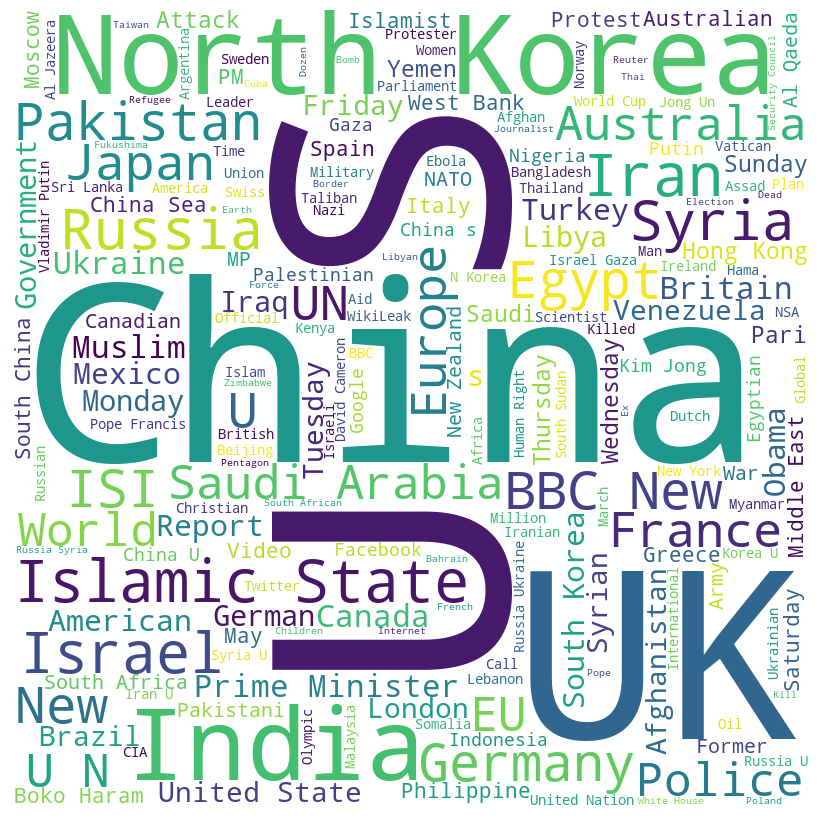

In [ ]:
# Convert the DataFrame to a list of words
words_list = [row.word for row in dfWordTag.collect()]

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(' '.join(words_list))

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
# Show the plot
plt.show()


# Sentiment Analysis

In [4]:
# Import necessary libraries
from pyspark.ml import PipelineModel
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
#from sparknlp.base import *
#from sparknlp.annotator import *
from pyspark.ml import Pipeline
#from sparknlp.pretrained import PretrainedPipeline 
#from pyspark.ml import PipelineModel
from pyspark.sql.functions import length

In [5]:
pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.6/769.6 kB 5.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...


True

In [7]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F


In [ ]:
#Check for duplicates
counts = df.groupby(df.time_created).count()
duplicates = counts.filter(col("count") > 1)
duplicates.show()

In [ ]:
#Count of duplicates
df.createOrReplaceTempView("data")
print(spark.sql("SELECT count(DISTINCT time_created) FROM data").show())
spark.sql("SELECT count(time_created) FROM data").show()

In [ ]:
#Create identifier unique_ID
from pyspark.sql.functions import monotonically_increasing_id
new_df = df.withColumn("unique_ID", monotonically_increasing_id())

In [ ]:
#Creating a copy of new_df and storing it as df for further analysis
df = new_df.copy()

In [ ]:
#Isolate relevant columns into new DF
new_new_df = new_df.select("unique_ID","title")

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Define a UDF to find the sentiment of a title
def find_sentiment(title):
    if title is None:
        return "Neutral"
    if sia.polarity_scores(title)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(title)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"

# Register the UDF
find_sentiment_udf = udf(find_sentiment, StringType())

# Add a new column "title_sentiment" to the existing DataFrame "df"
df = df.withColumn("title_sentiment", find_sentiment_udf("title"))

# Show the result
df.show()


+------------+------------+--------+----------+--------------------+-------+--------------+---------+---------------+
|time_created|date_created|up_votes|down_votes|               title|over_18|        author|subreddit|title_sentiment|
+------------+------------+--------+----------+--------------------+-------+--------------+---------+---------------+
|  1201232046|  2008-01-25|       3|         0|Scores killed in ...|  False|         polar|worldnews|       Negative|
|  1201232075|  2008-01-25|       2|         0|Japan resumes ref...|  False|         polar|worldnews|        Neutral|
|  1201232523|  2008-01-25|       3|         0|US presses Egypt ...|  False|         polar|worldnews|        Neutral|
|  1201233290|  2008-01-25|       1|         0|Jump-start econom...|  False|       fadi420|worldnews|       Positive|
|  1201274720|  2008-01-25|       4|         0|Council of Europe...|  False|      mhermans|worldnews|       Negative|
|  1201287889|  2008-01-25|      15|         0|Hay prest

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create three different DataFrames based on the sentiment values
df_positive = df.filter(df.title_sentiment == 'Positive')
df_negative = df.filter(df.title_sentiment == 'Negative')
df_neutral = df.filter((df.title_sentiment == 'Neutral') & (df.title.isNotNull())) 

# Concatenate the titles from each DataFrame into three separate strings
positive_titles = ' '.join(df_positive.select('title').rdd.flatMap(lambda x: x).collect())
negative_titles = ' '.join(df_negative.select('title').rdd.flatMap(lambda x: x).collect())
neutral_titles = ' '.join(df_neutral.select('title').rdd.flatMap(lambda x: x).collect())


In [ ]:
# Generate word clouds for each sentiment category
wordcloud_positive = WordCloud(width = 800, height = 800,background_color="white", min_font_size = 10).generate(positive_titles)
wordcloud_negative = WordCloud(width = 800, height = 800,background_color="white", min_font_size = 10).generate(negative_titles)
wordcloud_neutral = WordCloud(width = 800, height = 800,background_color="white", min_font_size = 10).generate(neutral_titles)

Word Cloud for Positive Sentiment

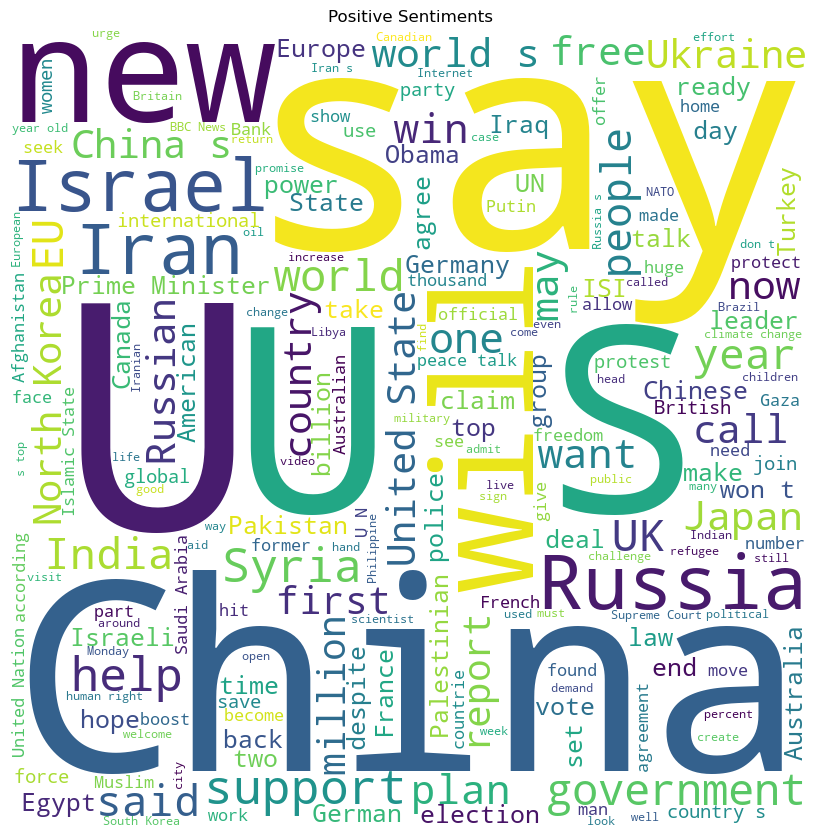

In [ ]:
# Display the word cloud for positive sentiment
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Positive Sentiments")
plt.show()


Word Cloud for Negative Sentiment

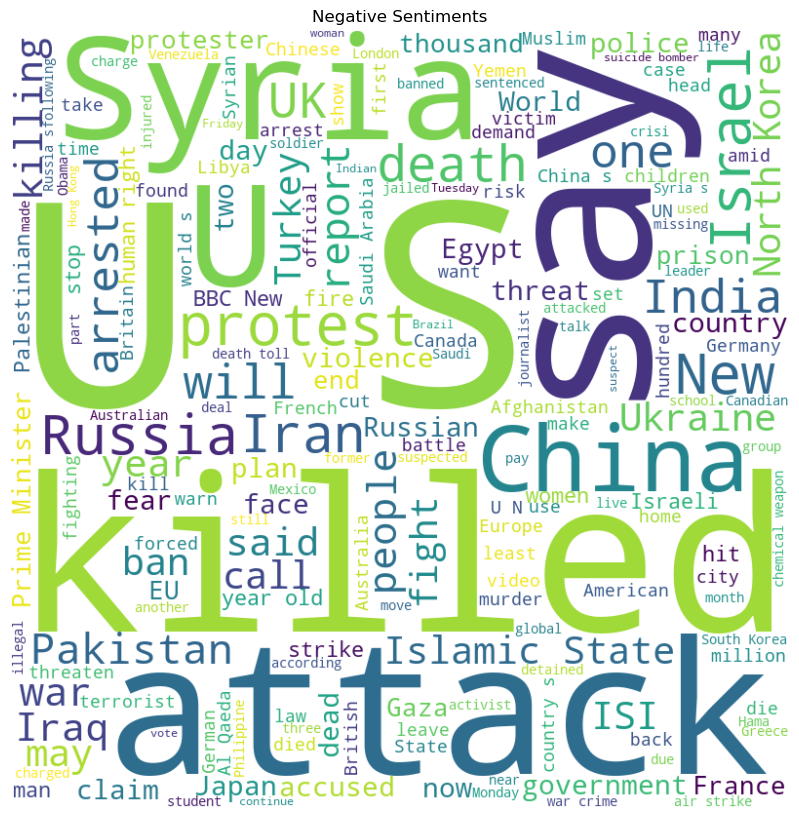

In [ ]:
# Display the word cloud for negative sentiment
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Sentiments")
plt.tight_layout(pad = 0)
plt.show()

Word Cloud for Neutral Sentiment

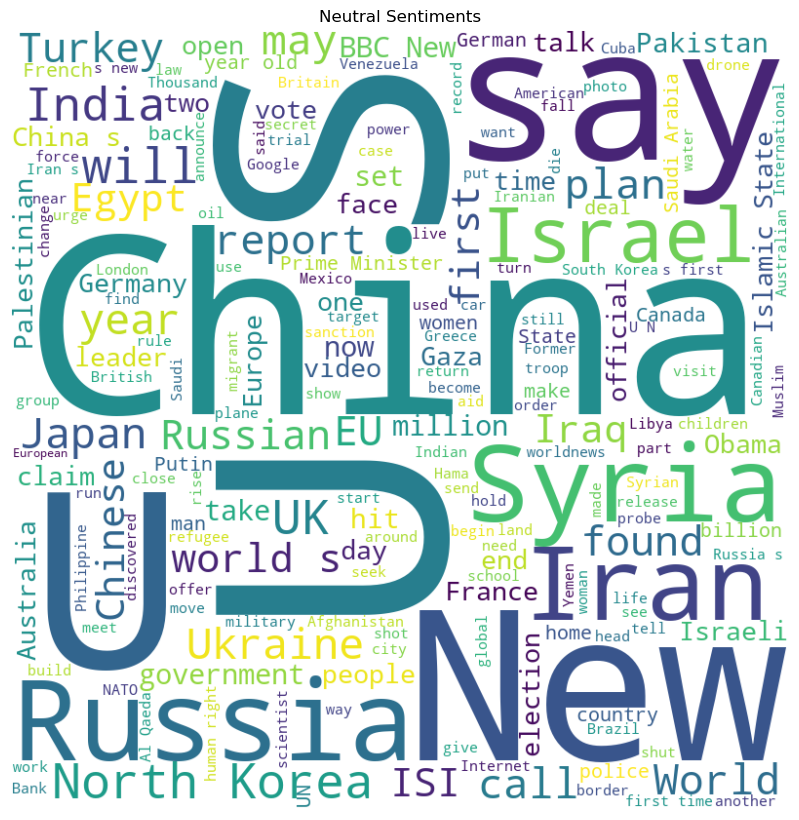

In [ ]:
# Display the word cloud for neutral sentiment
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title("Neutral Sentiments")
plt.tight_layout(pad = 0)
plt.show()

Without Countries

In [18]:
### NEW CELL ###

# Define lists of countries and nationalities
countries = ['US', 'U.S','Russia','Iran','Syria','UK','North Korea','Afghanistan', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia, Plurinational State of', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heard Island and McDonald Islands', 'Holy See (Vatican City State)', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', "Korea, Democratic People's Republic of", 'Korea, Republic of', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Macedonia, Republic of', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Mexico', 'Micronesia, Federated States of', 'Moldova, Republic of', 'Monaco', 'Mongolia', 'Montenegro', 'Montserrat', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestinian Territory, Occupied', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Pitcairn', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Réunion', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Georgia and the South Sandwich Islands', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'South Sudan', 'Svalbard and Jan Mayen', 'Swaziland', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Taiwan, Province of China', 'Tajikistan', 'Tanzania, United Republic of', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'United States Minor Outlying Islands', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela, Bolivarian Republic of', 'Viet Nam', 'Virgin Islands, British', 'Virgin Islands, U.S.', 'Wallis and Futuna', 'Yemen', 'Zambia', 'Zimbabwe', 'Islamic State']

nationalities = ['Afghan', 'Albanian', 'Algerian', 'American', 'Andorran', 'Angolan', 'Antiguans', 'Argentinean', 'Armenian', 'Australian', 'Austrian', 'Azerbaijani', 'Bahamian', 'Bahraini', 'Bangladeshi', 'Barbadian', 'Barbudans', 'Batswana', 'Belarusian', 'Belgian', 'Belizean', 'Beninese', 'Bhutanese', 'Bolivian', 'Bosnian', 'Brazilian', 'British', 'Bruneian', 'Bulgarian', 'Burkinabe', 'Burmese', 'Burundian', 'Cambodian', 'Cameroonian', 'Canadian', 'Cape Verdean', 'Central African', 'Chadian', 'Chilean', 'Chinese', 'Colombian', 'Comoran',  'Congolese', 'Costa Rican', 'Croatian', 'Cuban', 'Cypriot', 'Czech', 'Danish', 'Djibouti', 'Dominican', 'Dutch', 'Dutchman', 'Dutchwoman', 'East Timorese', 'Ecuadorean', 'Egyptian', 'Emirian', 'Equatorial Guinean', 'Eritrean', 'Estonian', 'Ethiopian', 'Fijian', 'Filipino', 'Finnish', 'French', 'Gabonese', 'Gambian', 'Georgian', 'German', 'Ghanaian', 'Greek', 'Grenadian', 'Guatemalan', 'Guinea-Bissauan', 'Guinean', 'Guyanese', 'Haitian', 'Herzegovinian', 'Honduran', 'Hungarian', 'I-Kiribati', 'Icelander', 'Indian', 'Indonesian', 'Iranian', 'Iraqi', 'Irish', 'Israeli', 'Italian', 'Ivorian', 'Jamaican', 'Japanese', 'Jordanian', 'Kazakhstani', 'Kenyan', 'Kittian and Nevisian', 'Kuwaiti', 'Kyrgyz', 'Laotian', 'Latvian', 'Lebanese', 'Liberian', 'Libyan', 'Liechtensteiner', 'Lithuanian', 'Luxembourger', 'Macedonian', 'Malagasy', 'Malawian', 'Malaysian', 'Maldivan', 'Malian', 'Maltese', 'Marshallese', 'Mauritanian', 'Mauritian', 'Mexican', 'Micronesian', 'Moldovan', 'Monacan', 'Mongolian', 'Moroccan', 'Mosotho', 'Motswana', 'Mozambican', 'Namibian', 'Nauruan', 'Nepalese', 'Netherlander', 'New Zealander', 'Ni-Vanuatu', 'Nicaraguan', 'Nigerian', 'Nigerien', 'North Korean', 'Northern Irish', 'Norwegian', 'Omani', 'Pakistani', 'Palauan', 'Panamanian', 'Papua New Guinean', 'Paraguayan', 'Peruvian', 'Polish', 'Portuguese', 'Qatari', 'Romanian', 'Russian', 'Rwandan', 'Saint Lucian', 'Salvadoran', 'Samoan', 'San Marinese', 'Sao Tomean', 'Saudi', 'Scottish', 'Senegalese', 'Serbian', 'Seychellois', 'Sierra Leonean', 'Singaporean', 'Slovakian', 'Slovenian', 'Solomon Islander', 'Somali', 'South African', 'South Korean', 'Spanish', 'Sri Lankan', 'Sudanese', 'Surinamer', 'Swazi', 'Swedish', 'Swiss', 'Syrian', 'Taiwanese', 'Tajik', 'Tanzanian', 'Thai', 'Togolese', 'Tongan', 'Trinidadian or Tobagonian', 'Tunisian', 'Turkish', 'Tuvaluan', 'Ugandan', 'Ukrainian', 'Uruguayan', 'Uzbekistani', 'Venezuelan', 'Vietnamese', 'Welsh', 'Yemenite', 'Zambian', 'Zimbabwean']


# Filter out countries and nationalities from each string
for word_list in [countries, nationalities]:
    for word in word_list:
        positive_titles = positive_titles.replace(word, '')
        negative_titles = negative_titles.replace(word, '')
        neutral_titles = neutral_titles.replace(word, '')


In [19]:
# Generate word clouds for each sentiment category
wordcloud_positive = WordCloud(width = 800, height = 800,background_color="white", min_font_size = 10).generate(positive_titles)
wordcloud_negative = WordCloud(width = 800, height = 800,background_color="white", min_font_size = 10).generate(negative_titles)
wordcloud_neutral = WordCloud(width = 800, height = 800,background_color="white", min_font_size = 10).generate(neutral_titles)

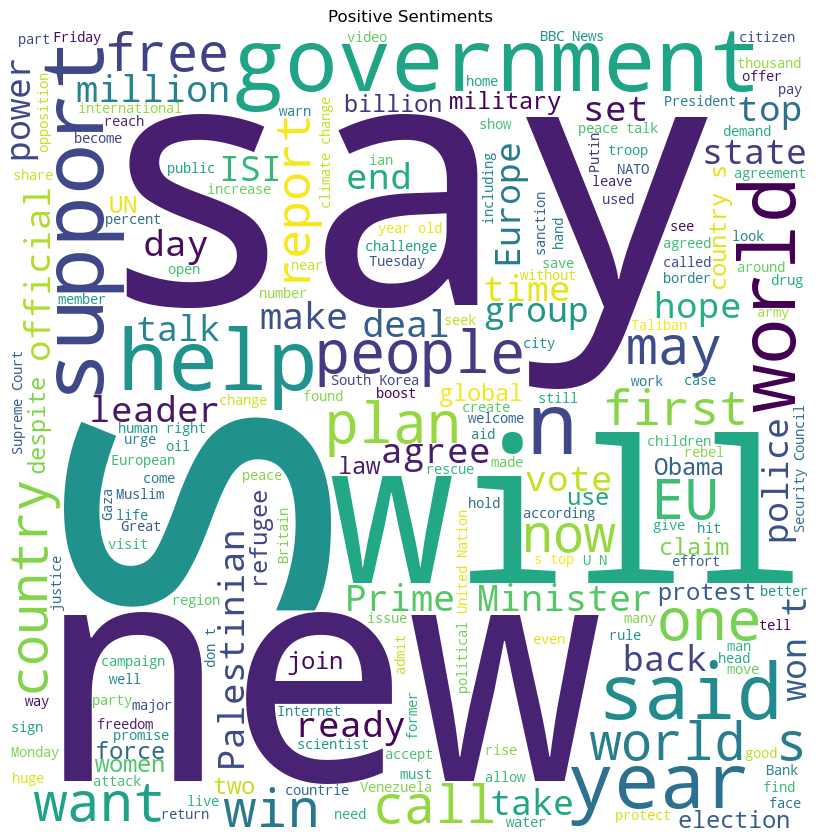

In [20]:
# Display the word cloud for positive sentiment
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Positive Sentiments")
plt.show()


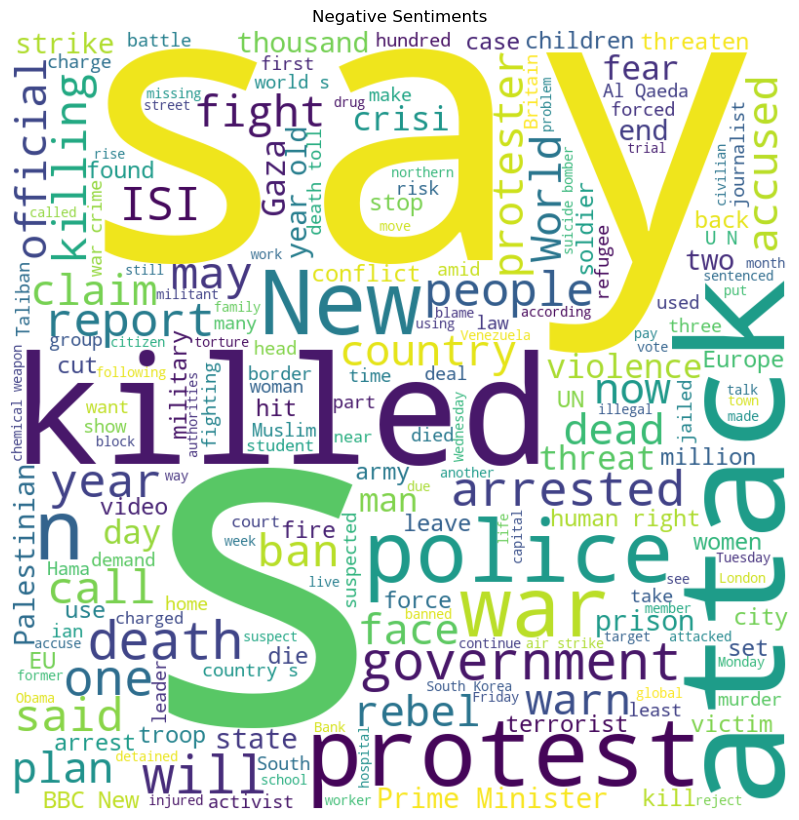

In [21]:
# Display the word cloud for negative sentiment
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Sentiments")
plt.tight_layout(pad = 0)
plt.show()

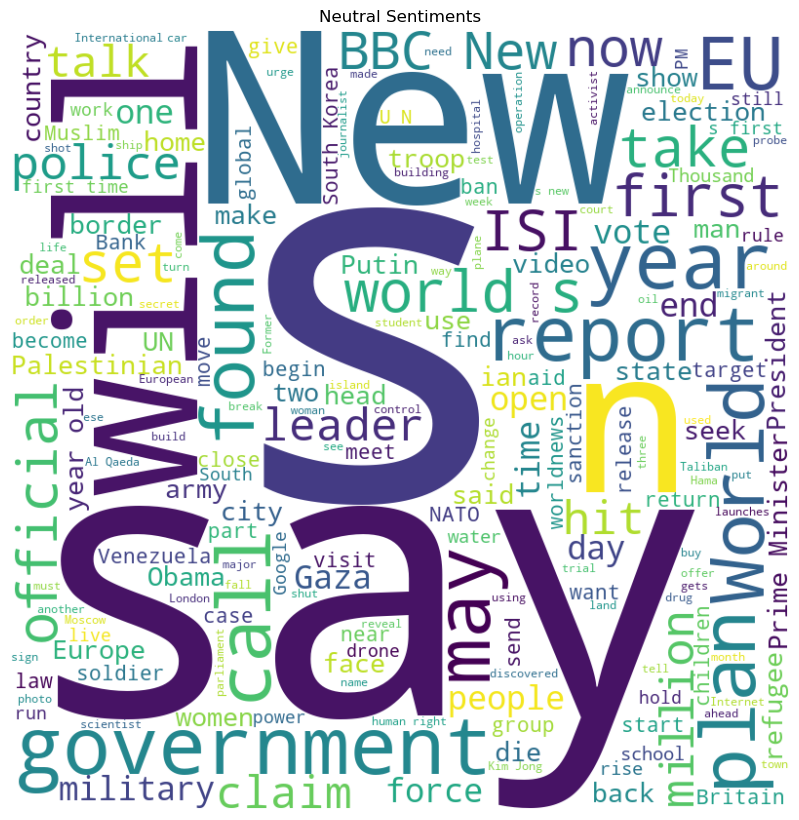

In [22]:
# Display the word cloud for neutral sentiment
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title("Neutral Sentiments")
plt.tight_layout(pad = 0)
plt.show()